In [11]:
import util.bench as bench
import models.SNPLogisticRegression as models
import matplotlib.pyplot as plt
import numpy as np

In [3]:
num_benchs = 100
n = 1000
m = 100
k = 5


# semi-parallel log regression with covariates

fit regression with const matrix(covariates are the same for each SNP for one person), then do 1 iteration of Newton-Rhapsod(NR) with SNP term in regression.

semi-parallel approach is realized in firstly doing one regression with covariates for all SNPs and then doing one iteration of NR for all SNP simultaneously(calculate S_star and not for each column of S separately)

In [3]:
semi_parallel_model = models.SemiParallelSNPLogRegression()
bench_res = bench.bench_model(semi_parallel_model, num_benchs, n, m, k)
msips_paral = bench_res["msip"]
print(f"Semi-parallel approach average speed: {msips_paral.mean():.2f} Msips\n")

Semi-parallel approach average speed: 13.60 Msips



non semi-parallel approach - fit regression for each SNP separately

In [4]:
brute_force_model = models.BruteForceSNPLogRegression()
bench_res = bench.bench_model(brute_force_model, num_benchs, n, m, k)
msips_brute = bench_res["msip"]
print(f"Brute force approach average speed: {msips_brute.mean():.2f} Msips\n")

KeyboardInterrupt: 

In [12]:
print(f"Semi-parallel is {msips_paral.mean() / msips_brute.mean():.2f} times faster")

Semi-parallel is 47.11 times faster


<Figure size 640x480 with 0 Axes>

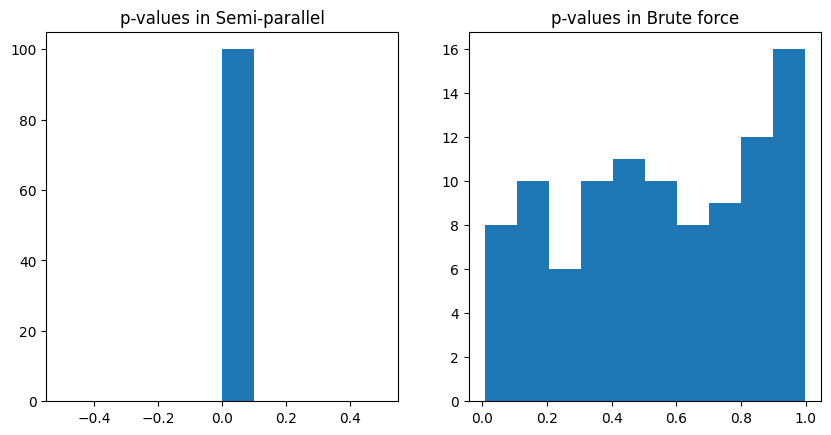

<Figure size 640x480 with 0 Axes>

In [13]:
y, S, X = bench.gen_random_data(2013, n, m, k)
semi_par = models.SemiParallelSNPLogRegression()
semi_par.fit(y,S,X)

brute_forc = models.BruteForceSNPLogRegression()
brute_forc.fit(y,S,X)

fig, axes = plt.subplots(1,2)
fig.set_figwidth(10)
axes[0].hist(semi_par.pvalues)
axes[0].set_title("p-values in Semi-parallel")

axes[1].hist(brute_forc.pvalues)
axes[1].set_title("p-values in Brute force")

plt.figure()
# smth is wrong again...

Difference in p-values predicted by exact and approximate alglorithms

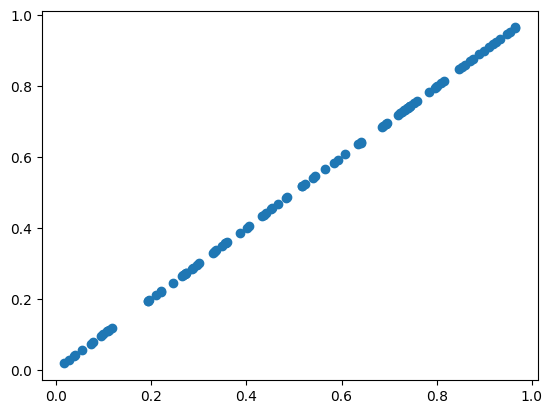

In [11]:
h = 100
p1 = np.zeros(h)
p2 = np.zeros(h)

for i in range(h):
    np.random.seed(i)
    n = 1000 # samples
    m = 1 # SNPs
    k = 5 # num of covariates

    S = np.random.normal(0, 1, size=(n, m)) # SNP matrix
    X0 = np.random.uniform(0, 1, size=(n, k)) # covariates matrix 
    ones = np.zeros(n) + 1
    X = np.append(ones.reshape(n, 1), X0, axis=1)
    y = np.random.binomial(1, 0.5, n).reshape(n,1)

    model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
    p = model.fittedvalues.reshape(n,1)

    w = p * (1 - p) # diag matrix with const elem
    z = np.log(p / (1 - p)) + (y - p) / (p * (1 - p))
    xtw = (X * w).T # X^T * W
    U1 = xtw @ z
    U2 = np.linalg.solve(xtw @ X, U1) # find betta_t, needed to find z*
    z_star = z - X @ U2
    U4 = np.linalg.solve(xtw @ X, xtw @ S) 
    S_star = S - X @ U4
    Str2 = np.sum(w * S_star**2, axis = 0) # m size vector of sums(w_i * s_i^2)
    beta = np.sum(z_star * w * S_star, axis=0) / Str2 # m size vect of sums(wi zi si) / str2
    err = Str2**-0.5
    pval = 2 * stat.norm.cdf(-np.abs(beta / err))

    X_si = np.append(S[:,0].reshape(n,1), X, axis=1)
    model = sm.GLM(y, X_si, family=sm.families.Binomial()).fit()
    pval_sep = model.pvalues[0]

    p1[i] = pval
    p2[i] = pval_sep
       
plt.plot(-np.log10(p1),-np.log10(p2),'o')


In [18]:
0.34/(10000 * 10000)

3.4000000000000003e-09